In [1]:
import numpy as np
import os 
os.environ["NUMBA_DISABLE_JIT"] = "1"
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
# from PyMPDATA import Options
# from PyMPDATA_examples.Smolarkiewicz_2006_Figs_3_4_10_11_12.simulation import Simulation
# from PyMPDATA_examples.Smolarkiewicz_2006_Figs_3_4_10_11_12.settings import Settings

In [2]:
import numpy as np
from PyMPDATA_examples.Smolarkiewicz_2006_Figs_3_4_10_11_12.settings import Settings
from PyMPDATA_examples.utils.discretisation import from_cdf_1d

from PyMPDATA import Options, ScalarField, Solver, Stepper, VectorField
from PyMPDATA.boundary_conditions import Periodic


class Simulation:
    def __init__(self, settings: Settings, options: Options):
        _, state = from_cdf_1d(
            settings.cdf, settings.x_min, settings.x_max, settings.nx
        )

        self.stepper = Solver(
            stepper=Stepper(
                options=options, n_dims=len(state.shape), non_unit_g_factor=False
            ),
            advectee=ScalarField(
                state.astype(options.dtype),
                halo=options.n_halo,
                boundary_conditions=(Periodic(),),
            ),
            advector=VectorField(
                (np.full(state.shape[0] + 1, settings.C, dtype=options.dtype),),
                halo=options.n_halo,
                boundary_conditions=(Periodic(),),
            ),
        )
        self.nt = settings.nt

    @property
    def state(self):
        return self.stepper.advectee.get().copy()

    def run(self):
        self.stepper.advance(self.nt)


In [3]:
import numpy as np
from pystrict import strict


@strict
class Settings:
    nt = 1600
    dt = 1
    nx = 500
    C = 0.5
    x_min = -250
    x_max = 250

    def __init__(self, shape: str):
        if shape == "cosine":
            self.cdf = Settings.cdf_cosine
        elif shape == "rect":
            self.cdf = Settings.cdf_rect
        else:
            raise ValueError()

    @staticmethod
    def cdf_cosine(x):
        x_mid = -150
        f = 2 / 12
        amplitude = 2

        pdf = np.where(np.abs(x - x_mid) < 10, amplitude * np.cos(f * (x - x_mid)), 0)
        return np.cumsum(pdf)

    @staticmethod
    def cdf_rect(x):
        x_mid = -150
        amplitude = 2
        offset = 2

        pdf = offset + np.where(np.abs(x - x_mid) <= 12, amplitude, 0)
        return np.cumsum(pdf)


In [4]:
def plot(simulation, filename, yshift=0):
    psi_0 = simulation.state
    simulation.run()
    psi_T = simulation.state
    x, dx = np.linspace(-250, 250, len(psi_T), retstep=True, endpoint=False)
    x += dx/2
    pyplot.figure(figsize=(7,4))
    pyplot.grid()
    pyplot.ylim(-2 + yshift, 4 + yshift)
    pyplot.xlim(-250, 250)
    pyplot.yticks(np.linspace(-2 + yshift, 4 + yshift, 4))
    pyplot.xticks(np.linspace(-250, 250, 6))
    pyplot.plot(x, psi_0)
    pyplot.plot(x, psi_T)
    show_plot(filename)

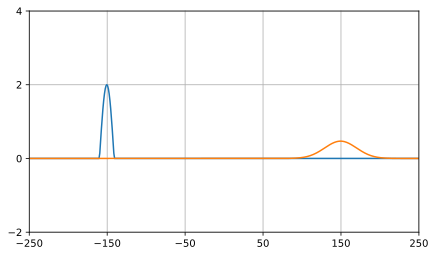

In [5]:
plot(Simulation(Settings("cosine"), Options(n_iters=1)), filename='fig_3')

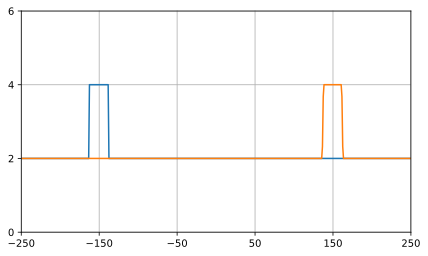

In [6]:
plot(Simulation(Settings("rect"), Options(n_iters=3, infinite_gauge=True, nonoscillatory=True)), filename='fig_12_3_iters', yshift=2)

In [6]:
# initial condition